# Regularization and Evaluation of Neural Networks

In [17]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.confusion import plot_confusion_matrix
    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Learning Objectives

- use `keras` to code up a neural network model;
- explain dropout and early stopping as distinctive forms of regularization in neural networks;
- use wrappers inside `keras` to make models that can jibe with `sklearn`.

### From last time

In [18]:
digits = load_digits()
X = digits.data
y = digits.target

y_binary = np.asarray(y_binary).astype('float32')

In [19]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X, y_binary, epochs=50, batch_size=10)

Epoch 1/50
180/180 [==============================] - 0s 372us/step - loss: 0.6130 - accuracy: 0.7056
Epoch 2/50
180/180 [==============================] - 0s 973us/step - loss: 0.2937 - accuracy: 0.8815
Epoch 3/50
180/180 [==============================] - 0s 361us/step - loss: 0.2038 - accuracy: 0.9260
Epoch 4/50
180/180 [==============================] - 0s 383us/step - loss: 0.1566 - accuracy: 0.9377
Epoch 5/50
180/180 [==============================] - 0s 356us/step - loss: 0.1258 - accuracy: 0.9527
Epoch 6/50
180/180 [==============================] - 0s 367us/step - loss: 0.1009 - accuracy: 0.9627
Epoch 7/50
180/180 [==============================] - 0s 761us/step - loss: 0.0873 - accuracy: 0.96770s - loss: 0.0875 - accuracy: 0.96
Epoch 8/50
180/180 [==============================] - 0s 361us/step - loss: 0.0783 - accuracy: 0.9705
Epoch 9/50
180/180 [==============================] - 0s 378us/step - loss: 0.0692 - accuracy: 0.9722
Epoch 10/50
180/180 [===========================

### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling
**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [20]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [21]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
12/12 [==============================] - 0s 417us/step - loss: 0.8156 - accuracy: 0.4961
Epoch 2/10
12/12 [==============================] - 0s 333us/step - loss: 0.7958 - accuracy: 0.4961
Epoch 3/10
12/12 [==============================] - 0s 333us/step - loss: 0.7792 - accuracy: 0.4961
Epoch 4/10
12/12 [==============================] - 0s 417us/step - loss: 0.7649 - accuracy: 0.4961
Epoch 5/10
12/12 [==============================] - 0s 417us/step - loss: 0.7528 - accuracy: 0.4961
Epoch 6/10
12/12 [==============================] - 0s 333us/step - loss: 0.7426 - accuracy: 0.4961
Epoch 7/10
12/12 [==============================] - 0s 333us/step - loss: 0.7344 - accuracy: 0.4961
Epoch 8/10
12/12 [==============================] - 0s 417us/step - loss: 0.7272 - accuracy: 0.4961
Epoch 9/10
12/12 [==============================] - 0s 6ms/step - loss: 0.7214 - accuracy: 0.4961
Epoch 10/10
12/12 [==============================] - 0s 417us/step - loss: 0.7164 - accuracy: 0.4961


We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [22]:
# dict
results.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x1d65d995520>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.8156428337097168,
   0.7958268523216248,
   0.7791900038719177,
   0.7649080753326416,
   0.7527751326560974,
   0.7426044344902039,
   0.7343736886978149,
   0.7272395491600037,
   0.7214056849479675,
   0.7163919806480408],
  'accuracy': [0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434,
   0.4960835576057434]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

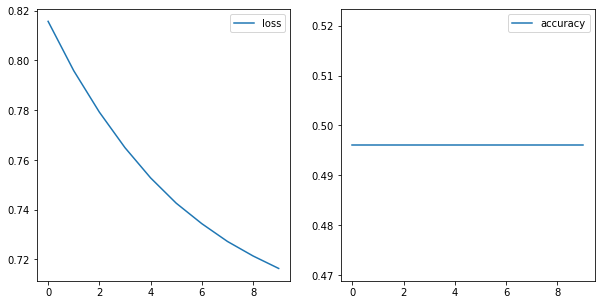

In [23]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

## Basic Model Tuning

### Increase Epochs

In [26]:
model = Sequential()
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
# increase epochs

results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=None, verbose=1)

Epoch 1/100
36/36 [==============================] - 0s 361us/step - loss: 0.7118 - accuracy: 0.5039
Epoch 2/100
36/36 [==============================] - 0s 333us/step - loss: 0.7049 - accuracy: 0.5039
Epoch 3/100
36/36 [==============================] - 0s 361us/step - loss: 0.7007 - accuracy: 0.5039
Epoch 4/100
36/36 [==============================] - 0s 389us/step - loss: 0.6980 - accuracy: 0.5039
Epoch 5/100
36/36 [==============================] - 0s 333us/step - loss: 0.6963 - accuracy: 0.5039
Epoch 6/100
36/36 [==============================] - 0s 417us/step - loss: 0.6953 - accuracy: 0.5039
Epoch 7/100
36/36 [==============================] - 0s 333us/step - loss: 0.6945 - accuracy: 0.5039
Epoch 8/100
36/36 [==============================] - 0s 333us/step - loss: 0.6939 - accuracy: 0.5039
Epoch 9/100
36/36 [==============================] - 0s 361us/step - loss: 0.6936 - accuracy: 0.5039
Epoch 10/100
36/36 [==============================] - 0s 361us/step - loss: 0.6932 - accura

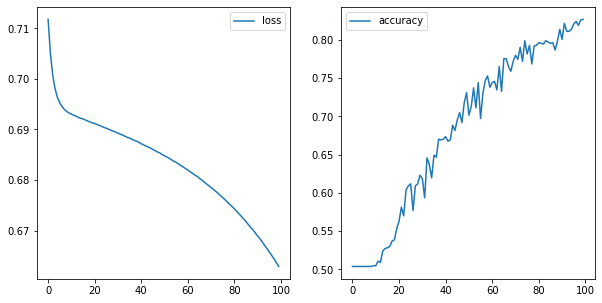

In [27]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Decrease Batch Size

In [28]:
model = Sequential()

model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# decrease batch size
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=10, verbose=1)

Epoch 1/10
115/115 [==============================] - 0s 374us/step - loss: 0.7170 - accuracy: 0.4961
Epoch 2/10
115/115 [==============================] - 0s 339us/step - loss: 0.6972 - accuracy: 0.4970
Epoch 3/10
115/115 [==============================] - 0s 348us/step - loss: 0.6940 - accuracy: 0.5117
Epoch 4/10
115/115 [==============================] - 0s 357us/step - loss: 0.6932 - accuracy: 0.5161
Epoch 5/10
115/115 [==============================] - 0s 339us/step - loss: 0.6927 - accuracy: 0.5152
Epoch 6/10
115/115 [==============================] - 0s 365us/step - loss: 0.6922 - accuracy: 0.5535
Epoch 7/10
115/115 [==============================] - 0s 391us/step - loss: 0.6916 - accuracy: 0.5057
Epoch 8/10
115/115 [==============================] - 0s 331us/step - loss: 0.6913 - accuracy: 0.5413
Epoch 9/10
115/115 [==============================] - 0s 365us/step - loss: 0.6907 - accuracy: 0.5335
Epoch 10/10
115/115 [==============================] - 0s 348us/step - loss: 0.690

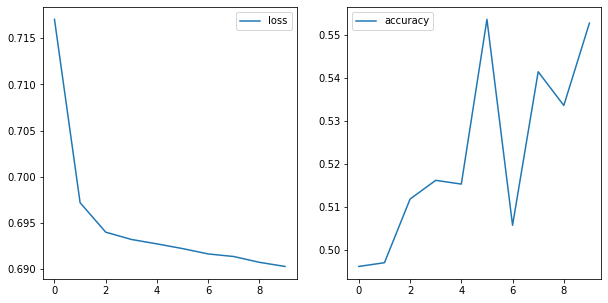

In [29]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Both

In [30]:
model = Sequential()

model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# increase epochs decrease batch size
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=10, verbose=1)

Epoch 1/100
115/115 [==============================] - 0s 357us/step - loss: 0.7306 - accuracy: 0.4961
Epoch 2/100
115/115 [==============================] - 0s 348us/step - loss: 0.6962 - accuracy: 0.4961
Epoch 3/100
115/115 [==============================] - 0s 357us/step - loss: 0.6915 - accuracy: 0.5309
Epoch 4/100
115/115 [==============================] - 0s 348us/step - loss: 0.6899 - accuracy: 0.5640
Epoch 5/100
115/115 [==============================] - 0s 365us/step - loss: 0.6892 - accuracy: 0.5674
Epoch 6/100
115/115 [==============================] - 0s 383us/step - loss: 0.6886 - accuracy: 0.6023
Epoch 7/100
115/115 [==============================] - 0s 357us/step - loss: 0.6878 - accuracy: 0.6110
Epoch 8/100
115/115 [==============================] - 0s 339us/step - loss: 0.6871 - accuracy: 0.6171
Epoch 9/100
115/115 [==============================] - 0s 357us/step - loss: 0.6864 - accuracy: 0.5788
Epoch 10/100
115/115 [==============================] - 0s 374us/step - l

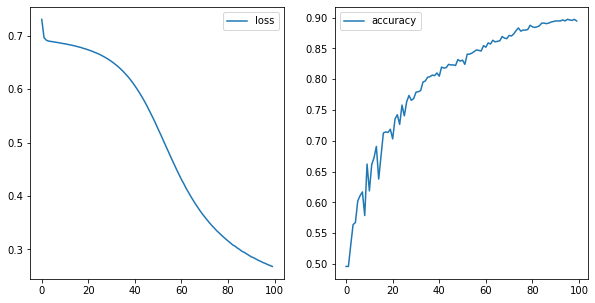

In [31]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Use Relu

In [35]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
# increase epochs, decrease batchsize


results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=None, verbose=1)

Epoch 1/100
36/36 [==============================] - 0s 418us/step - loss: 0.6916 - accuracy: 0.5500
Epoch 2/100
36/36 [==============================] - 0s 389us/step - loss: 0.6719 - accuracy: 0.5953
Epoch 3/100
36/36 [==============================] - 0s 361us/step - loss: 0.6599 - accuracy: 0.6519
Epoch 4/100
36/36 [==============================] - 0s 333us/step - loss: 0.6479 - accuracy: 0.6658
Epoch 5/100
36/36 [==============================] - 0s 361us/step - loss: 0.6345 - accuracy: 0.7093
Epoch 6/100
36/36 [==============================] - 0s 333us/step - loss: 0.6194 - accuracy: 0.7363
Epoch 7/100
36/36 [==============================] - 0s 361us/step - loss: 0.6039 - accuracy: 0.7528
Epoch 8/100
36/36 [==============================] - 0s 445us/step - loss: 0.5875 - accuracy: 0.7815
Epoch 9/100
36/36 [==============================] - 0s 389us/step - loss: 0.5700 - accuracy: 0.7955
Epoch 10/100
36/36 [==============================] - 0s 389us/step - loss: 0.5503 - accura

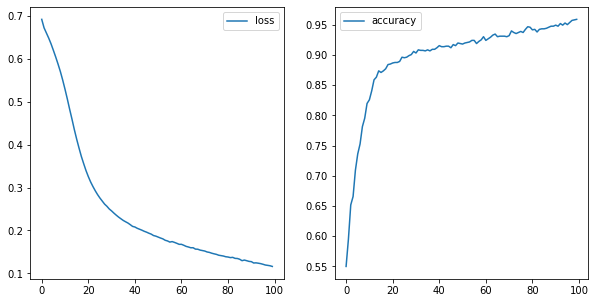

In [36]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### All of it (epochs, batch, relu)

In [37]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
# increase epochs

results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=10, verbose=1)


Epoch 1/100
115/115 [==============================] - 0s 339us/step - loss: 0.6743 - accuracy: 0.6214
Epoch 2/100
115/115 [==============================] - 0s 365us/step - loss: 0.6079 - accuracy: 0.7755
Epoch 3/100
115/115 [==============================] - 0s 348us/step - loss: 0.5420 - accuracy: 0.8155
Epoch 4/100
115/115 [==============================] - 0s 357us/step - loss: 0.4686 - accuracy: 0.8407
Epoch 5/100
115/115 [==============================] - 0s 357us/step - loss: 0.3976 - accuracy: 0.8547
Epoch 6/100
115/115 [==============================] - 0s 374us/step - loss: 0.3423 - accuracy: 0.8764
Epoch 7/100
115/115 [==============================] - 0s 357us/step - loss: 0.3008 - accuracy: 0.8947
Epoch 8/100
115/115 [==============================] - 0s 348us/step - loss: 0.2714 - accuracy: 0.9043
Epoch 9/100
115/115 [==============================] - 0s 357us/step - loss: 0.2507 - accuracy: 0.9077
Epoch 10/100
115/115 [==============================] - 0s 357us/step - l

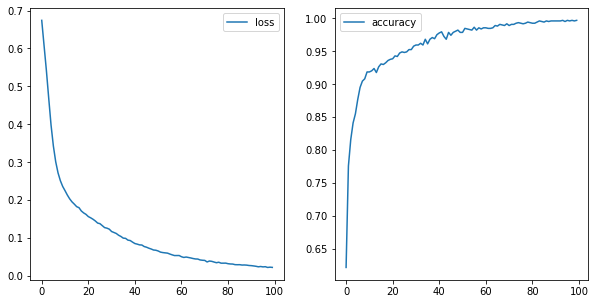

In [38]:
relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Side note: learning rate

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

Epoch 1/30
115/115 [==============================] - 0s 2ms/step - loss: 1.4433 - accuracy: 0.5083
Epoch 2/30
115/115 [==============================] - 0s 4ms/step - loss: 0.9810 - accuracy: 0.4978: 0s - loss: 1.0991 - accuracy: 0. - ETA: 0s - loss: 0.9817 - accuracy: 0.50 - ETA: 0s - loss: 0.9460 - accuracy: 0.
Epoch 3/30
115/115 [==============================] - 0s 3ms/step - loss: 0.9808 - accuracy: 0.5065
Epoch 4/30
115/115 [==============================] - 0s 400us/step - loss: 0.9833 - accuracy: 0.5170
Epoch 5/30
115/115 [==============================] - 0s 3ms/step - loss: 0.9997 - accuracy: 0.5030
Epoch 6/30
115/115 [==============================] - 0s 2ms/step - loss: 0.9585 - accuracy: 0.5152: 0s - loss: 0.9610 - accuracy: 
Epoch 7/30
115/115 [==============================] - 0s 374us/step - loss: 1.0250 - accuracy: 0.5074
Epoch 8/30
115/115 [==============================] - 0s 339us/step - loss: 1.0351 - accuracy: 0.5048
Epoch 9/30
115/115 [==========================

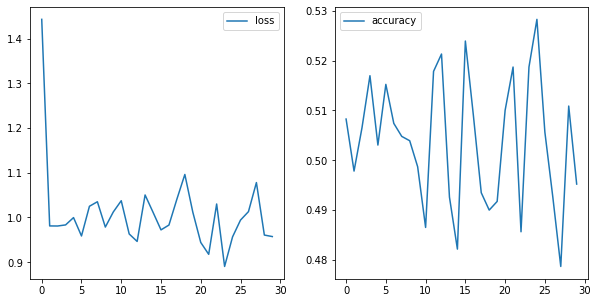

In [39]:
model = Sequential()

sgd = SGD(lr=9)


model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy')
ax1.legend();

### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

Epoch 1/100
115/115 [==============================] - 0s 2ms/step - loss: 0.6573 - accuracy: 0.5840 - val_loss: 0.6064 - val_accuracy: 0.7708
Epoch 2/100
115/115 [==============================] - 0s 565us/step - loss: 0.5510 - accuracy: 0.7702 - val_loss: 0.4830 - val_accuracy: 0.8368
Epoch 3/100
115/115 [==============================] - 0s 565us/step - loss: 0.4620 - accuracy: 0.8529 - val_loss: 0.4151 - val_accuracy: 0.8750
Epoch 4/100
115/115 [==============================] - 0s 1ms/step - loss: 0.4124 - accuracy: 0.8930 - val_loss: 0.3867 - val_accuracy: 0.9167
Epoch 5/100
115/115 [==============================] - 0s 2ms/step - loss: 0.3765 - accuracy: 0.9130 - val_loss: 0.3499 - val_accuracy: 0.9028
Epoch 6/100
115/115 [==============================] - 0s 1ms/step - loss: 0.3527 - accuracy: 0.9138 - val_loss: 0.3264 - val_accuracy: 0.9201
Epoch 7/100
115/115 [==============================] - 0s 791us/step - loss: 0.3314 - accuracy: 0.9199 - val_loss: 0.3079 - val_accuracy: 

Epoch 57/100
115/115 [==============================] - 0s 574us/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.0784 - val_accuracy: 0.9826
Epoch 58/100
115/115 [==============================] - 0s 557us/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 0.0692 - val_accuracy: 0.9826
Epoch 59/100
115/115 [==============================] - 0s 557us/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.0742 - val_accuracy: 0.9792
Epoch 60/100
115/115 [==============================] - 0s 548us/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.0837 - val_accuracy: 0.9826
Epoch 61/100
115/115 [==============================] - 0s 557us/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.0737 - val_accuracy: 0.9792
Epoch 62/100
115/115 [==============================] - 0s 557us/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.0714 - val_accuracy: 0.9792
Epoch 63/100
115/115 [==============================] - 0s 644us/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.0729 -

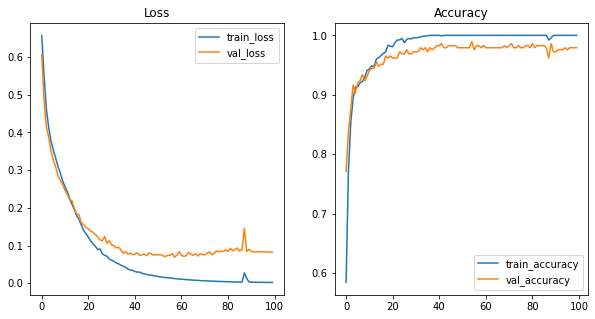

In [40]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


## YOUR CODE HERE
results = model.fit(X_pure_train, 
                    y_pure_train,
                    epochs=100, 
                    batch_size=10, 
                    verbose=1,
                   validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [41]:
results.history['val_accuracy'][-1]

0.9791666865348816

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [42]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001D65D450400> does not.

In [43]:
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [44]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=10,
                                          batch_size=32,
                                          verbose=2)

In [45]:
type(keras_model)

tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier

In [46]:
cross_val_score(keras_model, X_pure_train, y_pure_train)

Epoch 1/10
29/29 - 0s - loss: 0.6725 - accuracy: 0.6246
Epoch 2/10
29/29 - 0s - loss: 0.6036 - accuracy: 0.7856
Epoch 3/10
29/29 - 0s - loss: 0.5314 - accuracy: 0.8379
Epoch 4/10
29/29 - 0s - loss: 0.4474 - accuracy: 0.8640
Epoch 5/10
29/29 - 0s - loss: 0.3696 - accuracy: 0.8781
Epoch 6/10
29/29 - 0s - loss: 0.3141 - accuracy: 0.8836
Epoch 7/10
29/29 - 0s - loss: 0.2788 - accuracy: 0.8945
Epoch 8/10
29/29 - 0s - loss: 0.2536 - accuracy: 0.9032
Epoch 9/10
29/29 - 0s - loss: 0.2378 - accuracy: 0.9108
Epoch 10/10
29/29 - 0s - loss: 0.2232 - accuracy: 0.9173
8/8 - 0s - loss: 0.2708 - accuracy: 0.8826
Epoch 1/10
29/29 - 0s - loss: 0.6674 - accuracy: 0.5822
Epoch 2/10
29/29 - 0s - loss: 0.5925 - accuracy: 0.7454
Epoch 3/10
29/29 - 0s - loss: 0.5033 - accuracy: 0.8183
Epoch 4/10
29/29 - 0s - loss: 0.4167 - accuracy: 0.8379
Epoch 5/10
29/29 - 0s - loss: 0.3440 - accuracy: 0.8607
Epoch 6/10
29/29 - 0s - loss: 0.2948 - accuracy: 0.8716
Epoch 7/10
29/29 - 0s - loss: 0.2556 - accuracy: 0.8912
Epoc

array([0.88260871, 0.9130435 , 0.90869564, 0.92608696, 0.86462879])

## [Regularization](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer)

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

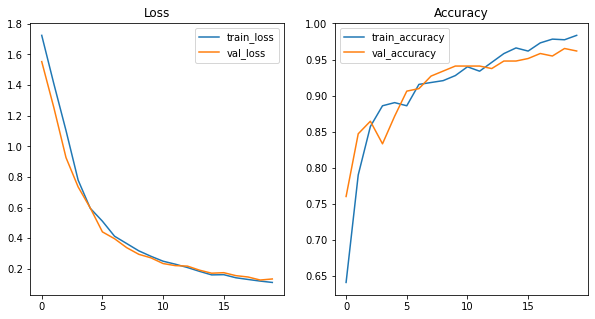

In [47]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu',kernel_regularizer=l2(l=0.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

Adding L2 to multiple layers:

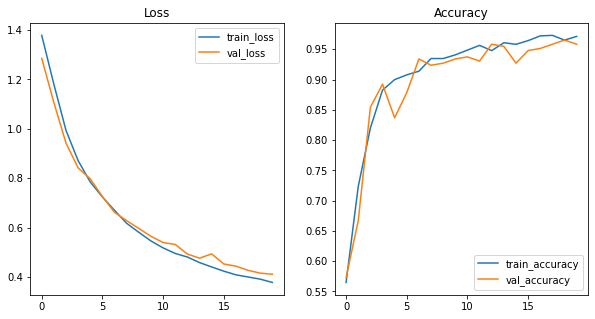

In [48]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](images/drop_out.png)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

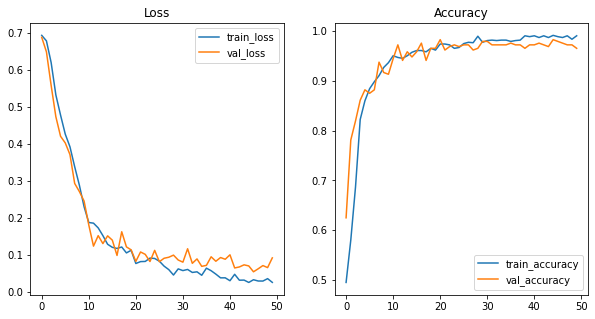

In [51]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [50]:
results.history['val_accuracy'][-1]

0.9826388955116272

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

Epoch 00015: early stopping


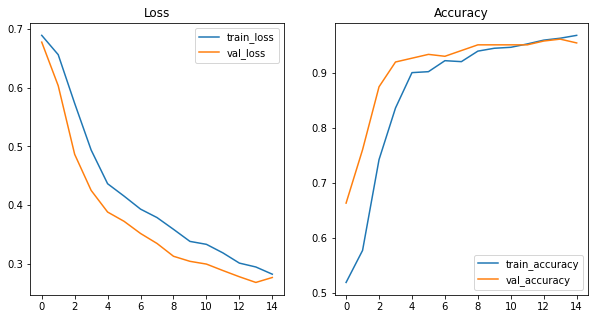

In [52]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

Epoch 1/50
36/36 [==============================] - 0s 5ms/step - loss: 0.6943 - accuracy: 0.5144 - val_loss: 0.6904 - val_accuracy: 0.5694
Epoch 2/50
36/36 [==============================] - 0s 778us/step - loss: 0.6649 - accuracy: 0.6049 - val_loss: 0.6173 - val_accuracy: 0.7188
Epoch 3/50
36/36 [==============================] - 0s 834us/step - loss: 0.5347 - accuracy: 0.7476 - val_loss: 0.4244 - val_accuracy: 0.8160
Epoch 4/50
36/36 [==============================] - 0s 806us/step - loss: 0.3941 - accuracy: 0.8242 - val_loss: 0.3080 - val_accuracy: 0.8715
Epoch 5/50
36/36 [==============================] - 0s 889us/step - loss: 0.3314 - accuracy: 0.8529 - val_loss: 0.2391 - val_accuracy: 0.9167
Epoch 6/50
36/36 [==============================] - 0s 861us/step - loss: 0.2933 - accuracy: 0.8764 - val_loss: 0.1968 - val_accuracy: 0.9236
Epoch 7/50
36/36 [==============================] - 0s 861us/step - loss: 0.2498 - accuracy: 0.8956 - val_loss: 0.1761 - val_accuracy: 0.9201
Epoch 8/

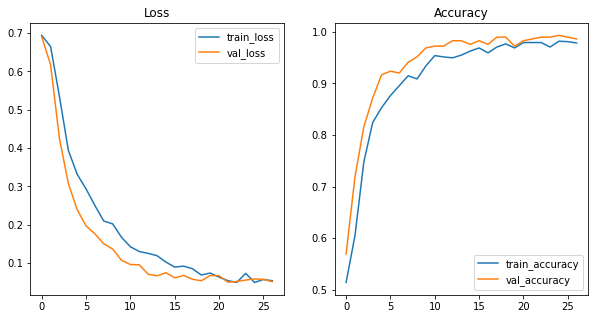

In [55]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss',  #Note: validation data needs to be provided in model!!!!
                           min_delta=1e-8,
                           verbose=2, 
                           patience=5,  #How many epochs of min delta before break?
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=1, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [56]:
results.history['val_accuracy'][-1]

0.9861111044883728

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [57]:
digits = load_digits()
X = digits.data
y = digits.target

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For a multiclass output, our neural net expects our target to be in a certain form.

In [59]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [60]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [61]:
y_test.shape

(360, 10)

In [62]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Epoch 1/50
115/115 [==============================] - 0s 1ms/step - loss: 2.2534 - accuracy: 0.1462 - val_loss: 2.1637 - val_accuracy: 0.1771
Epoch 2/50
115/115 [==============================] - 0s 539us/step - loss: 2.0430 - accuracy: 0.2811 - val_loss: 1.8947 - val_accuracy: 0.3507
Epoch 3/50
115/115 [==============================] - 0s 1ms/step - loss: 1.7082 - accuracy: 0.4456 - val_loss: 1.5330 - val_accuracy: 0.5208
Epoch 4/50
115/115 [==============================] - 0s 522us/step - loss: 1.3597 - accuracy: 0.6066 - val_loss: 1.2426 - val_accuracy: 0.6736
Epoch 5/50
115/115 [==============================] - 0s 504us/step - loss: 1.1112 - accuracy: 0.7032 - val_loss: 1.0388 - val_accuracy: 0.6910
Epoch 6/50
115/115 [==============================] - 0s 513us/step - loss: 0.9415 - accuracy: 0.7493 - val_loss: 0.9131 - val_accuracy: 0.7500
Epoch 7/50
115/115 [==============================] - 0s 504us/step - loss: 0.8213 - accuracy: 0.7815 - val_loss: 0.8129 - val_accuracy: 0.7

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [63]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

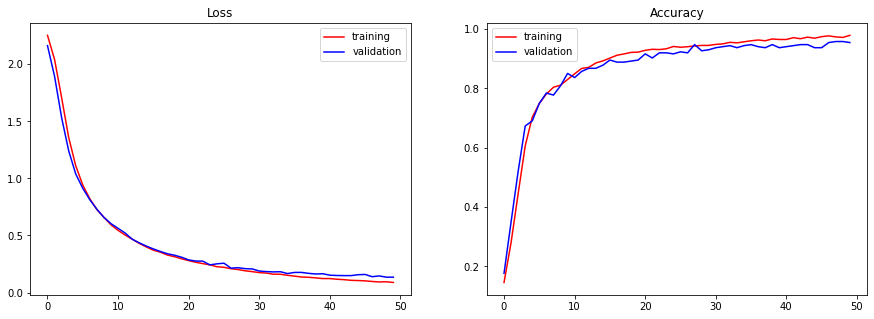

In [64]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)

ax1.set_title('Loss')
ax2.set_title('Accuracy')
ax1.legend();

In [65]:
preds = model.predict(X_test)

In [70]:
preds[0].max(), preds[0].argmax()

(0.99957794, 6)

In [71]:
X_test.shape

(360, 64)

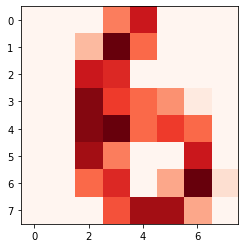

In [75]:
plt.imshow(X_test[0].reshape(8,8),cmap='Reds')

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

We will explore more advanced tools in the coming days.


In [81]:
y_test_restored = ohe.inverse_transform(y_test)
y_test_restored

array([[6],
       [9],
       [3],
       [7],
       [2],
       [1],
       [5],
       [2],
       [5],
       [2],
       [1],
       [9],
       [4],
       [0],
       [4],
       [2],
       [3],
       [7],
       [8],
       [8],
       [4],
       [3],
       [9],
       [7],
       [5],
       [6],
       [3],
       [5],
       [6],
       [3],
       [4],
       [9],
       [1],
       [4],
       [4],
       [6],
       [9],
       [4],
       [7],
       [6],
       [6],
       [9],
       [1],
       [3],
       [6],
       [1],
       [3],
       [0],
       [6],
       [5],
       [5],
       [1],
       [9],
       [5],
       [6],
       [0],
       [9],
       [0],
       [0],
       [1],
       [0],
       [4],
       [5],
       [2],
       [4],
       [5],
       [7],
       [0],
       [7],
       [5],
       [9],
       [5],
       [5],
       [4],
       [7],
       [0],
       [4],
       [5],
       [5],
       [9],
       [9],
       [0],
       [2],
    

In [79]:
y_hat = np.argmax(preds,axis=1)
y_hat

array([6, 9, 3, 7, 3, 1, 5, 2, 5, 2, 1, 8, 4, 0, 4, 2, 3, 7, 8, 8, 4, 3,
       9, 7, 5, 6, 3, 5, 6, 3, 4, 9, 1, 4, 4, 6, 9, 4, 7, 6, 6, 9, 1, 3,
       6, 1, 3, 0, 6, 5, 5, 1, 9, 5, 6, 0, 9, 0, 0, 1, 0, 4, 5, 2, 4, 5,
       7, 0, 7, 5, 9, 5, 5, 4, 7, 0, 7, 5, 5, 9, 9, 0, 2, 3, 8, 0, 6, 4,
       4, 9, 1, 2, 8, 3, 5, 2, 9, 0, 4, 4, 4, 3, 5, 3, 1, 3, 5, 9, 4, 2,
       7, 7, 4, 4, 1, 9, 2, 7, 8, 7, 2, 6, 9, 4, 0, 7, 3, 7, 5, 8, 7, 5,
       7, 9, 0, 6, 6, 4, 2, 8, 0, 9, 4, 6, 9, 9, 6, 9, 0, 5, 5, 6, 6, 0,
       6, 4, 1, 9, 3, 7, 7, 2, 9, 0, 4, 5, 3, 6, 5, 8, 9, 8, 4, 2, 1, 3,
       7, 7, 2, 2, 3, 9, 8, 0, 3, 2, 2, 5, 6, 9, 9, 4, 1, 5, 4, 2, 3, 6,
       4, 8, 5, 9, 5, 7, 8, 9, 4, 8, 1, 5, 4, 4, 9, 6, 1, 8, 6, 0, 4, 5,
       2, 7, 4, 6, 4, 5, 6, 0, 3, 2, 3, 6, 7, 1, 9, 1, 4, 7, 6, 5, 8, 5,
       5, 1, 0, 1, 8, 8, 9, 8, 7, 6, 2, 2, 2, 3, 4, 8, 8, 3, 6, 0, 1, 7,
       7, 0, 1, 0, 4, 5, 8, 5, 3, 6, 0, 4, 1, 0, 0, 3, 6, 5, 9, 7, 3, 5,
       5, 9, 9, 8, 5, 3, 3, 2, 0, 5, 8, 3, 4, 0, 2,

In [86]:
cm = confusion_matrix(y_test_restored,y_hat)

Confusion Matrix, without normalization
[[33  0  0  0  0  0  0  0  0  0]
 [ 0 26  0  0  0  0  0  0  1  1]
 [ 0  1 30  2  0  0  0  0  0  0]
 [ 0  1  0 32  0  1  0  0  0  0]
 [ 0  0  0  0 45  0  0  1  0  0]
 [ 0  0  0  0  0 45  1  0  0  1]
 [ 1  0  0  0  0  0 34  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  1]
 [ 0  1  0  0  0  1  0  1 27  0]
 [ 0  1  0  0  0  0  0  1  3 35]]


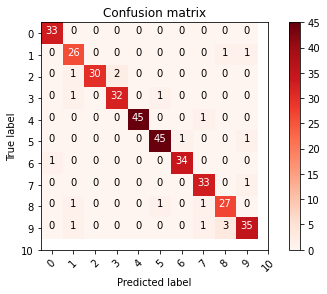

In [88]:
plot_confusion_matrix(cm,classes=np.arange(0,11),cmap='Reds')

In [90]:
from PIL import Image
new6 = Image.open('./images/Saads_six.png')
new6

In [93]:
X_test.shape

(360, 64)

In [111]:
img_array = np.array(new6)

In [ ]:
img_array[:,:,0].reshape(1,64).shape

In [123]:
test_array = np.array(img_array[:,:,0]-255)/255
test_array

array([[0.        , 0.        , 0.        , 0.97254902, 0.89411765,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.61568627, 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.70196078, 0.97254902, 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.96078431, 0.56862745, 0.95294118, 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.63137255, 0.        , 0.92156863, 0.8       ,
        0.75294118, 1.        , 0.        ],
       [0.        , 0.66666667, 0.        , 0.        , 0.        ,
        0.        , 0.70196078, 0.        ],
       [0.        , 0.67058824, 0.90588235, 0.        , 0.        ,
        0.81960784, 0.81568627, 0.        ],
       [0.        , 0.        , 0.79215686, 0.74509804, 0.72156863,
        0.89411765, 0.        , 0.        ]])

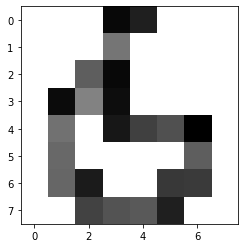

In [124]:
plt.imshow(test_array,cmap='Greys')

In [126]:
test_array.shape

(8, 8)

In [115]:
X_test[0]

array([0.    , 0.    , 0.    , 0.4375, 0.75  , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.25  , 1.    , 0.5   , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.75  , 0.6875, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.9375, 0.625 , 0.5   , 0.375 , 0.0625, 0.    ,
       0.    , 0.    , 0.9375, 1.    , 0.5   , 0.625 , 0.5   , 0.    ,
       0.    , 0.    , 0.875 , 0.4375, 0.    , 0.    , 0.75  , 0.    ,
       0.    , 0.    , 0.5   , 0.6875, 0.    , 0.3125, 1.    , 0.125 ,
       0.    , 0.    , 0.    , 0.5625, 0.875 , 0.875 , 0.3125, 0.    ])

In [127]:
model.predict(test_array.reshape(1,64))

array([[7.5238466e-04, 2.2834675e-07, 1.3709410e-13, 1.9880879e-08,
        1.5517108e-03, 2.4774115e-05, 9.7968221e-01, 9.0324175e-09,
        5.1065443e-05, 1.7937740e-02]], dtype=float32)

In [128]:
np.argmax(model.predict(test_array.reshape(1,64)))

6

In [130]:
model.predict(test_array.reshape(1,64)).max()

0.9796822